In [1]:
import os
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import numpy as np
import matplotlib.pyplot as plt
import sage 

/home/jlm217/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/stopah/data') 

pd.set_option('display.max_columns', None)  

ro.r['load']('STOPAH_ForSolon.RData')

def R_dataset(x):
    with (ro.default_converter + pandas2ri.converter).context():
        stopah = ro.conversion.get_conversion().rpy2py(ro.r[x])
    return stopah

stopah = R_dataset('stopah')

R[write to console]: Warning:
R[write to console]:  namespace ‘pROC’ is not available and has been replaced
by .GlobalEnv when processing object ‘roc.objs’



In [3]:
selected = ['D28_DTH','D90_DTH','Prednisolone']

baseline = ['Gender','Baseline_sepsis','Baseline_GIB',
'Age.at.randomisation..calc.','Weight','Max.grams.of.alcohol.drunk.per.day..calc.','Hepatic.Encephalopathy...Merged',
'Temperature...Merged','Pulse...Merged','Systolic.BP...Merged','Diastolic.BP...Merged','MAP','Hb...Merged','Platelets...Merged',
'WBC...Merged','Neutrophils...Merged','INR...Merged.clinical.and.calc','Bilirubin.Merged','ALT...Merged','ALP...Merged',
'Albumin...Merged','Sodium...Merged','Potassium...Merged','Urea...Merged','Creatinine...Merged','NLR_0','bDNA',
'Ferritin_ngml','Iron_mumoll','Transferrin','TSAT','PNPLA3_Add','PNPLA3_Rec','HPCT_NG'] 

sevenday = ['Hepatic.Encephalopathy...Treatment.Day.7..',
'Day.7.infection',
'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
'Temperature..Treatment.Day.7..',
'Pulse..Treatment.Day.7..',
'Systolic.BP..Treatment.Day.7..',
'Diastolic.BP..Treatment.Day.7..',
'MAP..Treatment.Day.7',
'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
'Platelets.day.7',
'WBC.day.7',
'Neutrophils.day.7',
'INR.clinical.and.calc.day.7',
'Bilirubin.day.7',
'ALT.day.7',
'ALP.day.7',
'Albumin.day.7',
'Sodium.day.7',
'Potassium.day.7',
'Urea.day.7',
'Creatinine.day.7']

#reduce data set to target, treatment and therapy

stopah = stopah[sevenday+['Prednisolone','D28_DTH']]

stopah.reset_index(drop=True, inplace=True)

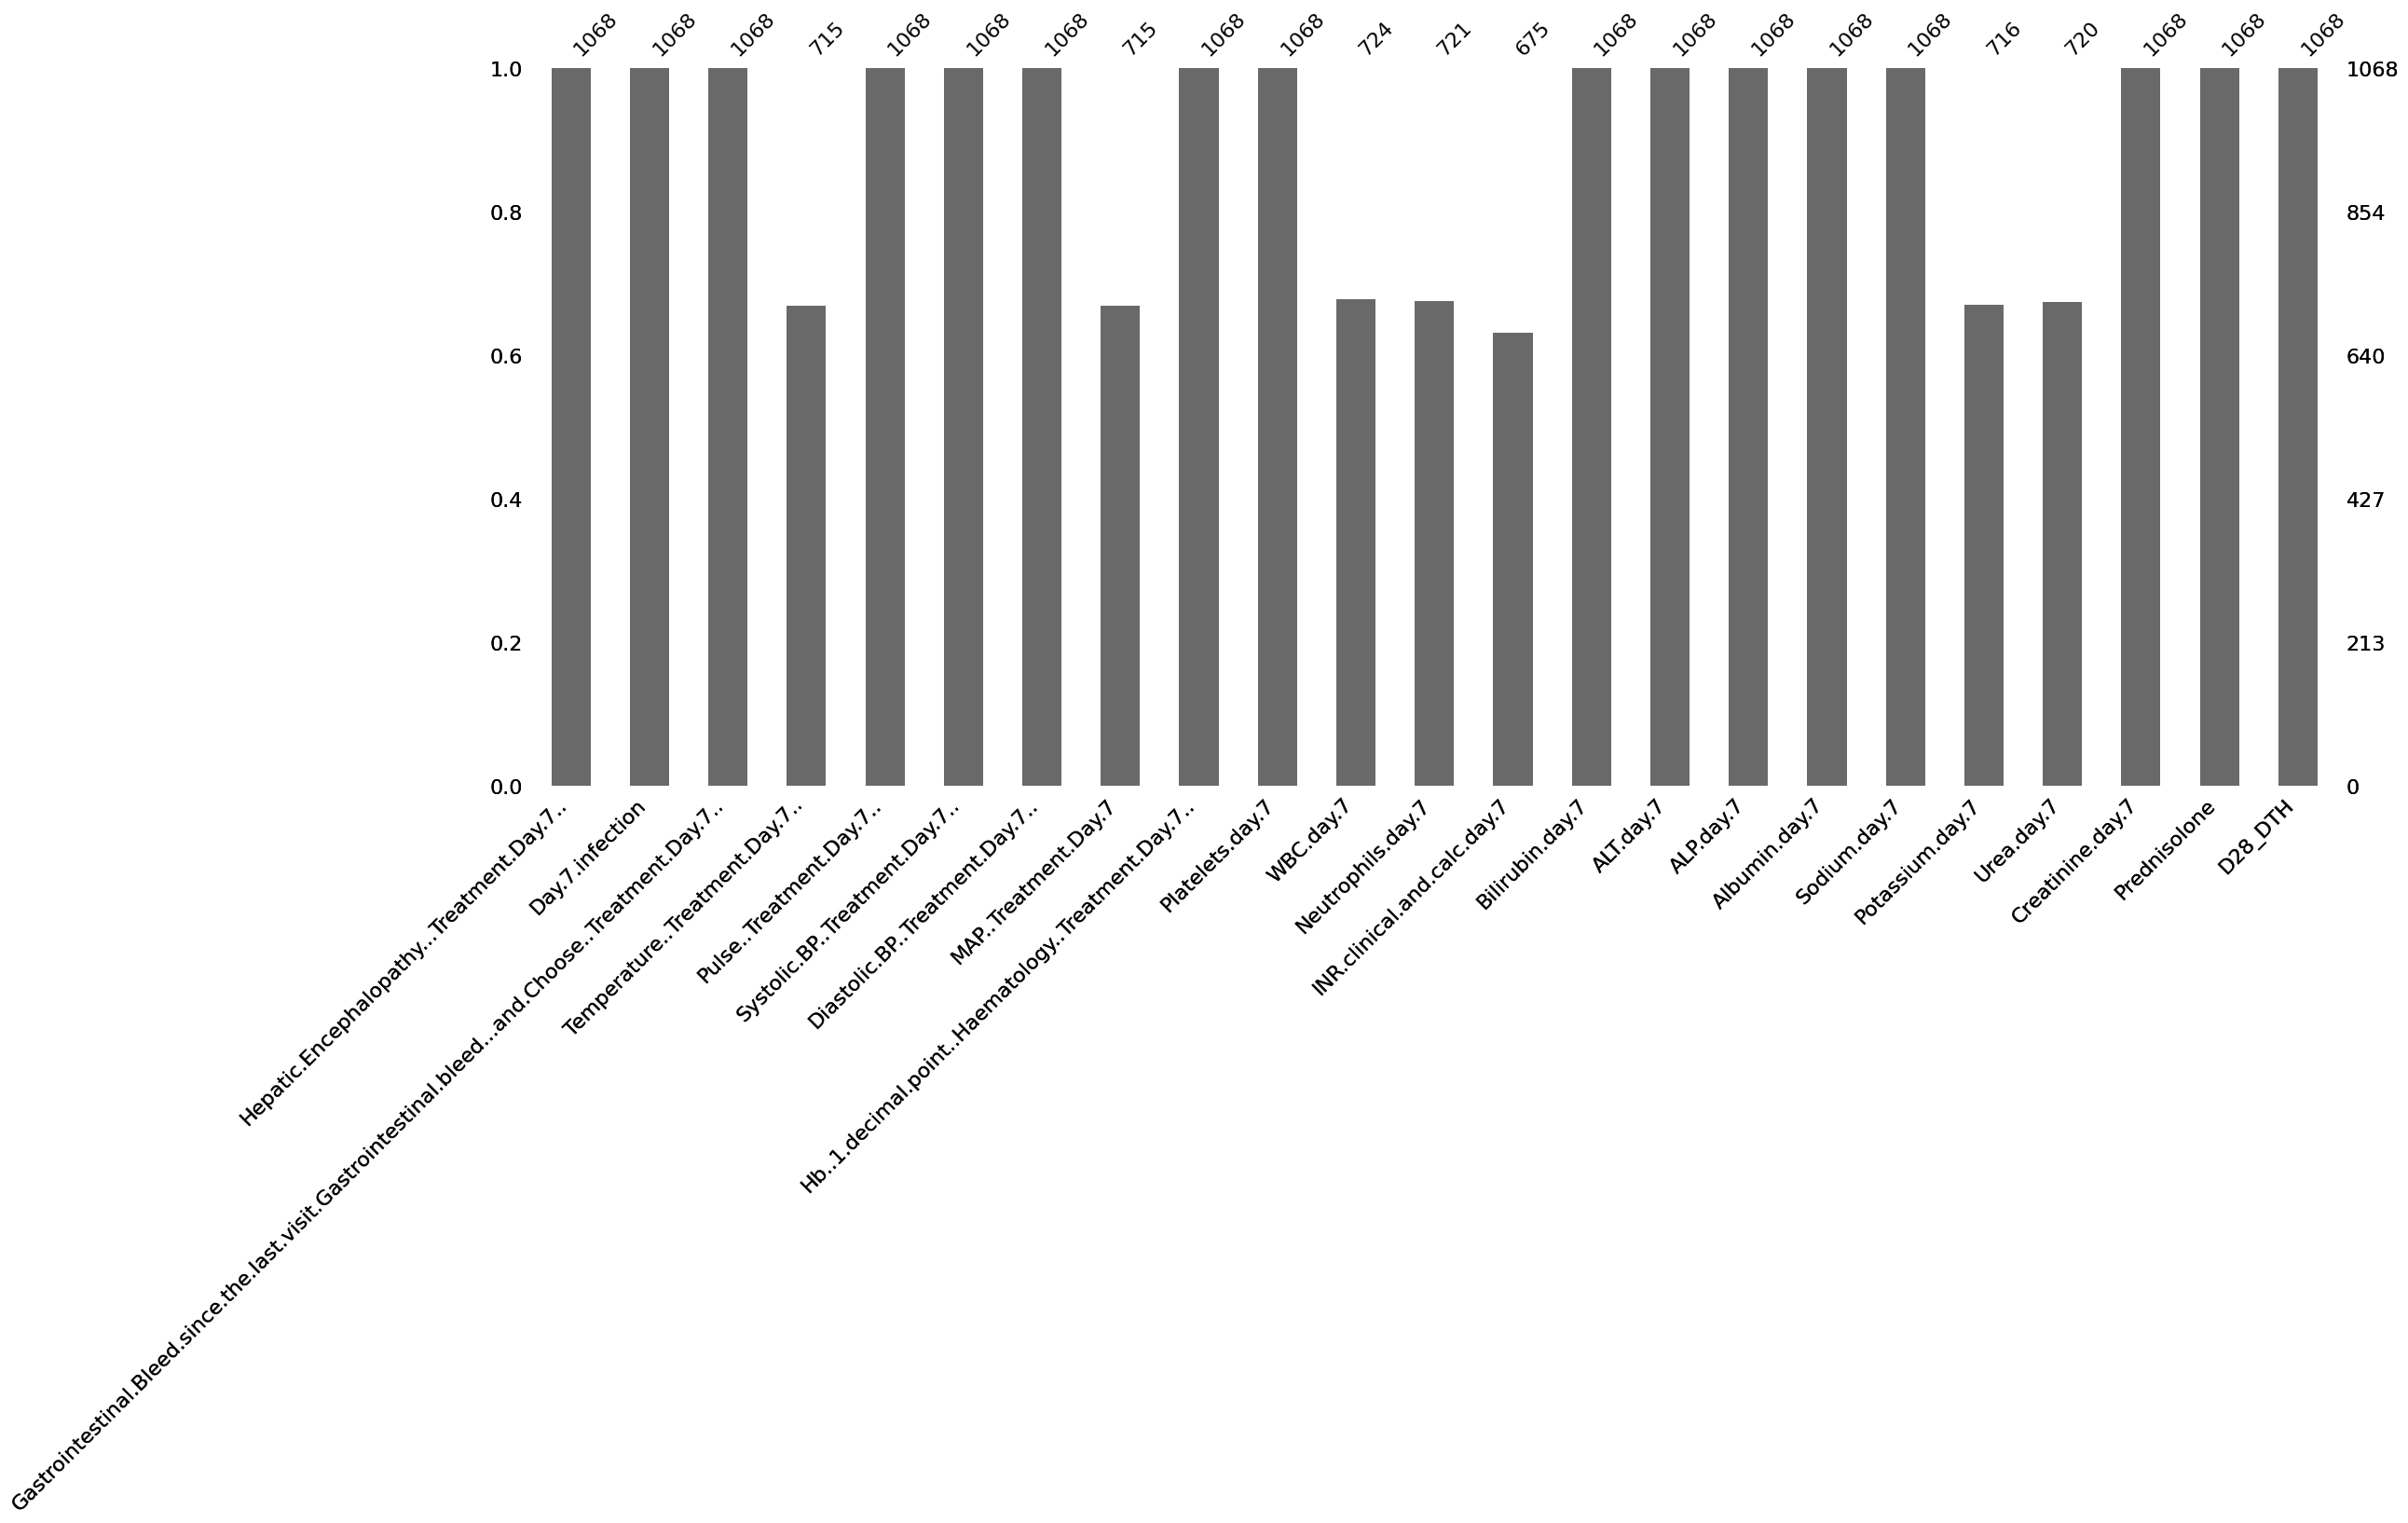

In [4]:
## Missing data situation

%matplotlib inline
msno.bar(stopah)
fig = msno.bar(stopah)
fig_copy = fig.get_figure()

In [5]:
df = stopah.dropna()

In [6]:
df = df[df['Prednisolone']==1].drop(['Prednisolone'],axis=1)

In [7]:
X, y = df.drop('D28_DTH', axis=1), df[['D28_DTH']]

In [8]:
cats = ['Hepatic.Encephalopathy...Treatment.Day.7..', 'Day.7.infection',
              'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..']


In [9]:
for col in cats:
    X[col] = X[col].astype('category')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [13]:
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [2]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10 # Every ten rounds
)

NameError: name 'dtest_reg' is not defined

In [16]:
results

NameError: name 'results' is not defined

In [1]:
params = {"objective": "multi:softprob", "tree_method": "gpu_hist", "num_class": 5}
n = 1000

results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=5,
   metrics=["mlogloss", "auc", "merror"],
)

NameError: name 'xgb' is not defined

In [17]:
x

,train-mlogloss-mean,train-mlogloss-std,train-auc-mean,train-auc-std,train-merror-mean,train-merror-std,test-mlogloss-mean,test-mlogloss-std,test-auc-mean,test-auc-std,test-merror-mean,test-merror-std
0,1.052050,0.012653,NaN,NaN,0.048442,0.009898,1.140038,0.041814,NaN,NaN,0.162626,0.045218
1,0.762877,0.017341,NaN,NaN,0.036063,0.009927,0.902514,0.059812,NaN,NaN,0.148990,0.040449
2,0.571306,0.016826,NaN,NaN,0.032686,0.011015,0.758242,0.072065,NaN,NaN,0.153434,0.027708
3,0.436342,0.013286,NaN,NaN,0.024789,0.009193,0.665424,0.087208,NaN,NaN,0.148990,0.034971
4,0.338790,0.012245,NaN,NaN,0.012398,0.005549,0.598631,0.107223,NaN,NaN,0.144545,0.042851
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.006784,0.000208,NaN,NaN,0.000000,0.000000,0.546047,0.242315,NaN,NaN,0.144545,0.037962
996,0.006784,0.000208,NaN,NaN,0.000000,0.000000,0.546046,0.242315,NaN,NaN,0.144545,0.037962
997,0.006784,0.000208,NaN,NaN,0.000000,0.000000,0.546046,0.242315,NaN,NaN,0.144545,0.037962
998,0.006784,0.000208,NaN,NaN,0.000000,0.000000,0.546045,0.242315,NaN,NaN,0.144545,0.037962
